# Model a _Normal_ distribution
This is equivalent to a linear model without predictors (`y ~ 1`): $y\sim\mathcal{N}(\mu, \sigma)$

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('dark')

# Statistical modelling
import pymc3 as pm

import theano 
import theano.tensor as tt

import patsy
import scipy.stats as st

In [2]:
# filter some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Set seed of the random number generator for reproducibility
SEED = 880123

## Generate artificial data

In [4]:
mu_real = 0
sd_real = 1

n_samples = 150

In [5]:
np.random.seed(SEED)

Y = np.random.normal(loc=mu_real, scale=sd_real, size=n_samples)

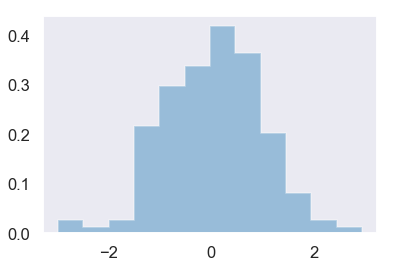

In [6]:
sns.distplot(Y, norm_hist=True, kde=False, hist_kws={'histtype':'stepfilled'});

In [7]:
print(f'Mean = {np.mean(Y).round(2)} \t Std = {np.std(Y).round(2)}')

Mean = 0.02 	 Std = 0.99


## Bayesian modelling

In [7]:
# Sampler settings
BURNIN=1000
TUNE=1000
SAMPLES=1000

### Build the model

In [8]:
with pm.Model() as model:
    
    # Prior on 'mu'
    mu = pm.Normal('mu', mu=0, sd=50)
    
    # Prior on 'sd'
    sd = pm.HalfNormal('sd', sd=50)
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sd=sd, observed=Y)

In [9]:
model.check_test_point()

mu             -4.83
sd_log__       -0.77
likelihood   -690.82
Name: Log-probability of test_point, dtype: float64

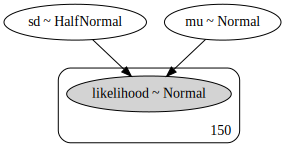

In [10]:
pm.model_to_graphviz(model)

### Sample from the model

In [11]:
with model:
    trace = pm.sample(draws=SAMPLES+BURNIN, tune=TUNE, chains=4, cores=1, random_seed=SEED)

# discard burnin samples
trace = trace[BURNIN:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sd, mu]
100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1290.60it/s]


### Diagnose the sampling

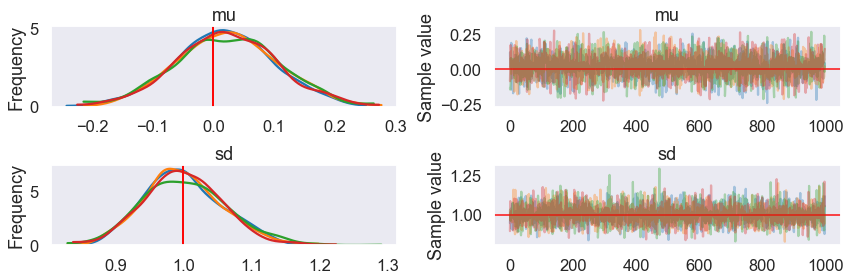

In [12]:
pm.traceplot(trace, lines={'mu':mu_real, 'sd':sd_real});

### Summarize the posterior density

In [14]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,0.02,0.08,0.0,-0.14,0.18,4172.22,1.0
sd,1.00,0.06,0.0,0.89,1.12,4023.63,1.0


### Posterior predictive check

mu = 0.02
sd = 1.0


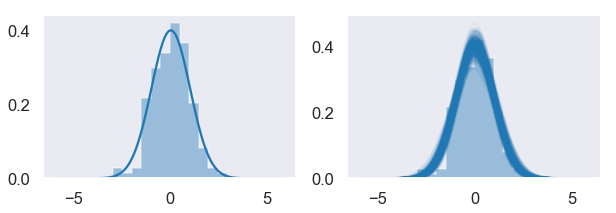

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

THIN = 10
X = np.arange(-6, 6, 0.1)

# Plot mean of the estimation
sns.distplot(Y, norm_hist=True, kde=False, label='Observations', hist_kws={'histtype':'stepfilled'}, ax=ax[0])
ax[0].plot(X, st.norm.pdf(x=X, loc=trace['mu'].mean(), scale=trace['sd'].mean()), alpha=1, color=sns.color_palette()[0])
print(f"mu = {trace['mu'].mean().round(2)}")
print(f"sd = {trace['sd'].mean().round(2)}")

# Plot smattering of curves
sns.distplot(Y, norm_hist=True, kde=False, label='Observations', hist_kws={'histtype':'stepfilled'}, ax=ax[1])

for mu, sd in zip(trace['mu'][::THIN], trace['sd'][::THIN]):
    ax[1].plot(X, st.norm.pdf(x=X, loc=mu, scale=sd), alpha=0.05, color=sns.color_palette()[0])


We can see that the observations agree well with the normal probability distributions generated by our model.

## Statistical inference

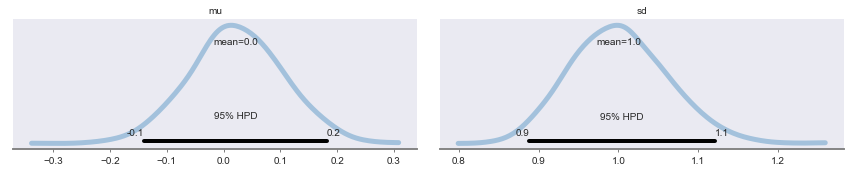

In [16]:
pm.plot_posterior(trace, varnames=['mu', 'sd'], round_to=1, kde_plot=True, lw=5);